# 0. Introduction

[This paper](https://link.springer.com/article/10.1007/s10822-021-00417-2) I recently came by discusses how to choose a classification model given the many possibilities available. As I read more on this subject, I decided to write this Notebook as a study guide. It ended up getting too big, and it has since been divided into more Notebooks/Tutorials, some that I still need to finish. I would appreciate any suggestions for their improvement.

The main topics discussed in this Notebook are the methods available to compare two classification models and determine which one is a better choice (and the statistic significance of this choice).

The other Notebooks discuss:
- The Bayes error rate, which is the lowest possible error rate (which is 1 - accuracy) any classifier can achieve on a dataset, and how to estimate it. You can find it [here](https://github.com/rflameiro/projects/blob/main/Bayes_Error_Rate_Estimation.ipynb)
- Estimation statistics: methods that go beyond hypothesis testing. I need to finish the discussion. Made a [notebook](https://github.com/rflameiro/projects/blob/main/R_REACT.ipynb) with a recent method that presents an alternative to Null Hypothesis Significance Testing. 
- Error analysis, which are methods to inspect the predictions made by a model, in particular, to understand the wrong predictions and propose ways to improve the model. (TO DO)

# 1. Evaluating the quality of classification models

Recommendations for the evaluation of machine learning models in cheminformatics have not strayed too far from other areas of machine learning. These include calculating metrics, such as accuracy, precision and recall for classification models, which reflect how well the model is able to predict correctly the classes of data points.

Model validation involves estimating the generalization error by using a model to predict unseen data points. This external dataset is often called validation and/or test set. Cross-validation is a technique that creates several dataset splits, allowing us to calculate the mean and standard deviation of the metrics.


## 1.1. Calculating quality metrics for a model 

The most common way to evaluate your model's performance involves training it with part of the dataset, followed by using the model to predict classes for the rest of the data points (data not used in training). This usually involves creating a test set, or by the use of cross-validation.

Then, classification metrics are calculated based on the predictions and the true values for the data points. Choosing the relevant metric is not always straightforward, as it can depend on the model application as well as on characteristics of the dataset, such as label imbalance.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split dataset randomly into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Use model to predict the labels of the test set
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auprc = average_precision_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
cohens_kappa = cohen_kappa_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.3f}')
print(f'AUPRC: {auprc:.3f}')
print(f'Balanced accuracy: {balanced_accuracy:.3f}')
print(f"Cohen's kappa: {cohens_kappa:.3f}")
print(f'F1 score: {f1:.3f}')
print(f'MCC: {mcc:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'ROC/AUC: {roc_auc:.3f}')


Accuracy: 0.855
AUPRC: 0.840
Balanced accuracy: 0.859
Cohen's kappa: 0.711
F1 score: 0.856
MCC: 0.717
Precision: 0.915
Recall: 0.804
ROC/AUC: 0.859


# 2. Statistical methods for model comparison

On the previous example, we calculated metrics for a model trained using a single algorithm, logistic regression. There are several machine learning algorithms available, and each one may present different metrics for your data set.

**Which model is better?** You may have asked yourself this question before. When researching the subject, we can find different answers, such as:

- A model with greater generalization capacity is better
- A simpler model is better than a more complex one (Occam's razor)
- An interpretable model is better than a "black box" model
- The model that makes the most correct predictions is the best
- The model that makes fewer wrong predictions for the class of interest is the best

And the list goes on...

Note that choosing one model over another presents itself as a more complex problem.

For each of the ways we use to determine the "quality" of our models, different approaches must be used. In this Notebook, we will deal with a specific question:

*For a given a dataset, how to identify which classification algorithm yields the best model?* 

In fact, we might begin by asking whether they are different from each other.

It is important that you make sure you are measuring exactly what you are supposed to be measuring. Therefore, this example assumes that you have already decided on the most relevant metric for your problem. Let's work with ROC/AUC for the following examples.


## 2.1. Comparaing ROC/AUC for every model

One approach you'll see in a lot of works involving machine learning models involves calculating one or more quality metrics, either using a test set or cross-validation, and directly comparing the calculated values.

Here's an example:

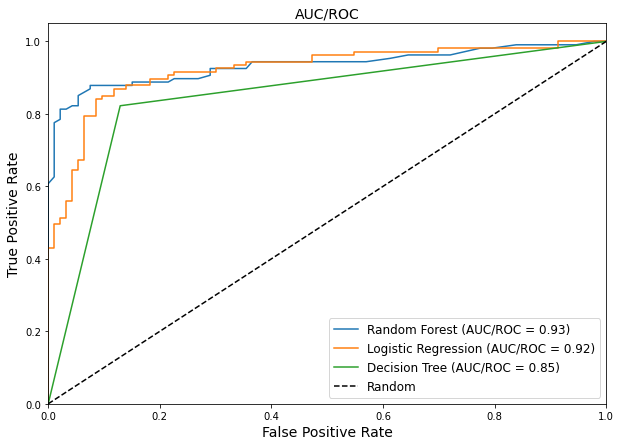

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split dataset randomly into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = [
    ('Random Forest', RandomForestClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier())
]

# Train and evaluate models
plt.figure(figsize=(10, 7))
for name, model in models:
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC/ROC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('AUC/ROC', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()

The general trend we see on published papers, especially those that present novel classification algorithms, is to indicate the model with the best score as "the best model" or "the better performing model".

In this case, the *Random Forest* model would be chosen as the best.

Note, however, that this is an **incorrect** approach.

How can we guarantee that the AUC value of 0.93 for the *Random Forest* model is truly greater than the 0.92 for the logistic regression model when we know that several sources of variability exist (especially for real data)?


## 2.2. Confidence intervals

Therefore, the next logic step is to calculate not only fixed values of the relevant metrics, but also their respective **confidence intervals**. The 95% interval is the most popular, which corresponds to 1.96 times the standard deviations (for Gaussian distributions).

If we want to proceed with our comparison with due statistical rigor, we need to combine the calculation of confidence intervals with some type of **hypothesis test** to decide whether our null hypothesis (both algorithms lead to the same classification performance) will be rejected or accepted.

The blog post [How to Calculate Bootstrap Confidence Intervals For Machine Learning Results in Python](https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/) presents a way to estimate the confidence intervals for classification metrics using the *bootstrapping* method. This  consists in performing repeated sampling with repetition, using these samples to train the model and calculating the desired metrics on the unselected samples (*out-of-bag*). See below an example adapted from the blog post:

###(ADD CODE)

In [ ]:
# import numpy
# from pandas import read_csv
# from sklearn.utils import resample
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# from matplotlib import pyplot

# # load dataset
# data = read_csv('pima-indians-diabetes.data.csv', header=None)
# values = data.values

# # configure bootstrap
# n_iterations = 500
# n_size = int(len(data) * 0.50)

# # run bootstrap
# stats = list()
# for i in range(n_iterations):
#     # prepare train and test sets
#     train = resample(values, n_samples=n_size)
#     test = numpy.array([x for x in values if x.tolist() not in train.tolist()])
#     # fit model
#     model = DecisionTreeClassifier()
#     model.fit(train[:,:-1], train[:,-1])
#     # evaluate model
#     predictions = model.predict(test[:,:-1])
#     score = accuracy_score(test[:,-1], predictions)
#     print(score)
#     stats.append(score)
    
# # plot scores
# pyplot.hist(stats)
# pyplot.show()

# # confidence intervals
# alpha = 0.95
# p = ((1.0-alpha)/2.0) * 100
# lower = max(0.0, numpy.percentile(stats, p))
# p = (alpha+((1.0-alpha)/2.0)) * 100
# upper = min(1.0, numpy.percentile(stats, p))
# print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

## 2.3. t-tests

Our first choice to compare models could be to use a simple t-test, such as the Student's t-test, to compare the means of the distributions for the metrics for the two models and identify whether they are different. However, this would not be an accurate choice. For a t-test to be valid, some [conditions](https://stats.stackexchange.com/questions/250282/how-to-use-cross-validation-for-model-comparison) should be met:
- Data must be normally distributed
- Data must have been drawn from independent distributions (i.i.d.)
- The variance within groups is equal within the population

Sample re-use methods, such as cross-validation and bootstraping, are often presented as a method of estimating the expected test error for a model. This, however, violates the assumption that the data are independent.

Furthermore, according to Blockeel (2011), estimating quality metrics using cross-validation (whether just once, such as 10-fold CV, or repeatedly, for example, 10 x 10-fold CV) has a disadvantage: when using the same data over and over again, we are calculating a value with high bias. Thus, repeated cross-validation does not allow an estimate of the true value of a metric for a model.

Therefore, we need alternative approaches.

## 2.4. Methods for comparing classification models: Dietterich (1998)

In a 1998 paper, Dietterich proposed two methods for comparing classification models. These methods demonstrated acceptable values of Type I (incorrectly detecting a significant difference between models when it does not exist) and Type II (not detecting a difference when it exists) errors. They are presented below:

### 2.4.1. 5×2cv paired t-test

The paired t-test with 5×2-*fold* cross-validation (5×2cv paired t-test) consists in performing five cycles of 2-fold cross-validation (that is, we separate the dataset into training/test sets in a 50/50 ratio five times). Next, a modified version of the paired t-test is performed.

According to the author, this method overcomes problems of the traditional paired t-test performed on cross-validation results, which are: underestimating the variance and, consequently, a high type I error.

The package [mlxtend](http://rasbt.github.io/mlxtend/), authored by Sebastian Raschka, provides an implementation of this method. See the documentation [here](http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/).

Let's start by training two classifiers and evaluating their accuracy on a test set:

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

clf1 = LogisticRegression(random_state=0)
clf2 = DecisionTreeClassifier(random_state=0)

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)

score_lr = roc_auc_score(clf1.predict(X_test), y_test)
score_dt = roc_auc_score(clf2.predict(X_test), y_test)

print(f'ROC/AUC Logistic Regression: {score_lr:.3f}' % (score_lr*100))
print(f'ROC/AUC Decision Tree: {score_dt:.3f}' % (score_dt*100))

ROC/AUC Logistic Regression: 0.967
ROC/AUC Decision Tree: 0.955


Note that these values, although numerically different, may not be significantly different.

Let's check if, in fact, we can say that a method is better, assuming a significance cutoff value (alpha) of 0.05:

In [17]:
# 5x2 cv t-test
# https://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
from mlxtend.evaluate import paired_ttest_5x2cv

clf1 = LogisticRegression(random_state=0)
clf2 = DecisionTreeClassifier(random_state=0)

t, p = paired_ttest_5x2cv(estimator1=clf1,
                          estimator2=clf2,
                          X=X, y=y,
                          random_seed=0)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.000
p value: 1.000


Since the p-value is greater than the alpha value (0.05), we cannot reject the null hypothesis, and we must conclude that the performance of the two methods is not significantly different.

### Comments

One problem with performing this test is that the train/test splits are chosen randomly, which might not be a good idea in cheminformatics.

Attention: if you are comparing the performance of more than one model, it is not correct to compare the p-values with the value 0.05 - it is necessary to apply, for example, the Bonferroni correction, which consists of dividing the alpha value by the number of models compared. So, if you are comparing 3 models, you will have to compare the p-values with 0.05/3 = 0.017. Therefore, you can only say that model A is significantly better than models B and C if the p-values for the AB and AC comparisons are less than 0.017.

### 2.3.2. McNemar's test

McNemar's Test is a non-parametric statistical hypothesis test for comparing two classification models. It is a chi-squared test.

This test is recommended when it is impractical to train multiple models on different subsets of the dataset (cross-validation), a common situation when working with neural networks.

To perform McNemar's test, start by splitting the dataset into training and test sets. Train the two classifiers you want to compare on the training set and predict the classes for the test set (McNemar's test requires that the sets used for prediction are **identical** for both models). The results for each prediction will belong to one of the following "classes":

- a: model 1 made a correct prediction and model 2 made a correct prediction
- b: model 1 made a correct prediction and model 2 made an incorrect prediction
- c: model 1 made an incorrect prediction and model 2 made a correct prediction
- d: model 1 made an incorrect prediction and model 2 made an incorrect prediction

These results can be written in the form of a table, called a **contingency table**:

|   |   |
|---|---|
| a | b |
| c | d |

Then, the McNemar statistic is calculated using the formula:

χ = (b-c)²/(b+c)

There is also a corrected version of this formula, proposed by [Edwards](https://en.wikipedia.org/wiki/McNemar%27s_test):

χ = (b-c-1)²/(b+c)

These formulas assume that the sum of the cells used in the calculation (b+c) is at least 25. Otherwise, a modified version of the test must be used, which calculates an exact p-value using a binomial distribution.

The mlextend and statsmodels packages have implementations of McNemar's test for all these cases.

Note that the chi-square value can be converted to a p-value, just like for the 5x2-CV test.

**mlextend**

The `mcnemar()` function of the mlextend module takes the contingency table as an argument and returns the calculated statistic and p-value.

Let's show how to use the `mcnemar_table()` function to generate the contingency table:

In [1]:
# Example: mlextend
import numpy as np
from mlxtend.evaluate import mcnemar_table

# The correct target (class) labels
y_target = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

# Class labels predicted by model 1
y_model1 = np.array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0])

# Class labels predicted by model 2
y_model2 = np.array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0])

tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_model1, 
                   y_model2=y_model2)

print(tb)

[[4 2]
 [1 3]]


After calculating the contingency table, we can calculate the statistics and p-values

Three options are available for the `mcnemar()` function, depending on the arguments used:

1. exact=True: Calculates an exact p-value using a binomial distribution. Recommended when b + c < 25
2. exact=False, corrected=True: uses the Edwards correction
3. exact=False, corrected=False: calculates the value without correction

In [ ]:
from mlxtend.evaluate import mcnemar

# Mcnemar's test - choose the appropriate version
chi2, p = mcnemar(ary=tb, exact=True)
# chi2, p = mcnemar(ary=tb, exact=False, corrected=False)
# chi2, p = mcnemar(ary=tb, exact=False, corrected=True)

print('chi-squared:', chi2)
print('p-value:', p)

# Interpret p-value
alpha = 0.05
if p > alpha:
     print('Same error proportions (we do not reject H0, the models are not different)')
else:
     print('Different error proportions (we reject H0, the models are different)')

**statsmodels**

The `mcnemar()` function in the statsmodels module takes the contingency table as an argument and returns the calculated statistic and p-value.

Three options are available, depending on the arguments used:

1. exact=True: Calculates an exact p-value using a binomial distribution. Recommended when b + c < 25
2. exact=False, correction=True: uses the Edwards correction
3. exact=False, correction=False: calculates the value without the correction

I set up a contingency table with random values. Since b+c > 25, we will use the corrected version of McNemar's test.

In [ ]:
# Example: statsmodels
from statsmodels.stats.contingency_tables import mcnemar

table = [[400, 25],
         [13, 300]]

# Mcnemar's test
# result = mcnemar(table, exact=True)
result = mcnemar(table, exact=False, correction=True)
# result = mcnemar(table, exact=False, correction=False)

# Show results
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

# Interpret p-value
alpha = 0.05
if result.pvalue > alpha:
     print('Same error proportions (we do not reject H0, the models are not different)')
else:
     print('Different error proportions (we reject H0, the models are different)')

In this [*blog post*](http://practicalcheinformatics.blogspot.com/2020/05/some-thoughts-on-comparing.html), the author performs the test 10 times using cross validation (9:1) and calculates the distribution and confidence intervals of the p-values, and regards as different the methods for which median is below the corrected alpha value (0.05/3, in the example).

## 2.4. Methods to compare classification models: Advances

Blockeel (2011) identifica em seu artigo *On Estimating Model Accuracy with Repeated Cross-Validation* mais três trabalhos que propõem métodos para comparar algoritmos.

### 2.4.1. 5×2cv F-test

Alpaydin (1999) improved the 5×2cv t-test by demonstrating that a 5×2cv F-test would be more robust, with lower type I error and greater statistical power.

This test is also available on [mlextend](https://rasbt.github.io/mlxtend/user_guide/evaluate/combined_ftest_5x2cv/).

In [ ]:
# 5x2 cv F-test
# https://rasbt.github.io/mlxtend/user_guide/evaluate/combined_ftest_5x2cv/
from mlxtend.evaluate import combined_ftest_5x2cv

f, p = combined_ftest_5x2cv(estimator1=knn_classifier,
                            estimator2=et_classifier,
                            X=X_train, y=y_train,
                            random_seed=123)

print('F statistic: %.3f' % f)
print('p-value: %.3f' % p)

### 2.4.2. 10×10cv with calibrated degrees of freedom

Bouckaert (2003) claims that 5×2cv, methods that involve resampling and 10-fold cv suffer from **low replicability**, and that the reuse of data causes the estimated variance to be smaller than the real variation, i.e., the effective degrees of freedom are much lower than theoretically expected, which increases Type I error.

The alternative presented in this work consists of using the 10 time repeated 10 fold cross validation (10×10cv) test and empirically calibrating the effective degrees of freedom.

In other words, the authors suggest multiplying the variance by a coefficient, based on the [correction proposed by Nadeau and Bengio](https://stats.stackexchange.com/questions/217466/for-model-selection-comparison-what-kind-of-test-should-i-use), and reducing the degrees of freedom for the 10×10cv from 99 to 10. Using 10×10cv should also improve replicability. 

[Check out this e-mail exchange between Bouckaert and Dietterich](https://wekalist.scms.waikato.ac.narkive.com/O5jqNlHe/10-by-10-way-cross-validation).


In [18]:
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


X, y = make_classification(n_samples=100, n_features=20, n_classes=2, random_state=0)

# Create 10x10 cv object
# Modify these for a different number of splits or repeats
n_splits=10
n_repeats=10
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)
# Use RepeatedStratifiedKFold for unbalanced datasets?

# Models
clf1 = LogisticRegression(random_state=0)
clf2 = DecisionTreeClassifier(random_state=0)

# We will "use all data", as explained in Bouckaert's e-mail,
# using ROC/AUC instead of accuracy
scores1 = cross_val_score(clf1, X, y, scoring='roc_auc', cv=cv)
scores2 = cross_val_score(clf2, X, y, scoring='roc_auc', cv=cv)


100


In [ ]:
# Calculating the corrected t-statistic

# Factors
n_samples = n_splits*n_repeats
df = 10  # calibrated value determined for the 10x10 cv 
diff_scores = scores1 - scores2
mean_diff_scores = diff_scores.mean()
var_diff_scores = diff_scores.var()

# Correction term for the variance
n1 = 1 - 1/n_splits  # fraction of the data used for training
n2 = 1/n_splits # fraction of the data used for testing
correction_factor_var = (1/n_samples) + (n2/n1)

# Corrected variance
corrected_var = var_diff_scores * correction_factor_var

# Corrected t-statistic
t = (mean_diff_scores * n_samples) / ( np.sqrt(corrected_var) / np.sqrt(df+1) )
print(f'10x10 cv t-statistic: {t:.3f}')

### 2.4.3. Other works

The two following papers discuss methods for comparing the general performance of algorithms, and not the comparison of trained models (predictors trained on a fixed training set), which is the aim of this Notebook. Therefore, I will comment on them briefly.

Nadeau and Bengio (2000) propose the corrected resampled t-test that takes into account the variability due to the choice of training set, and not only that due to the test examples. [Bouckaert and Frank](https://www.cs.waikato.ac.nz/~eibe/pubs/bouckaert_and_frank.pdf) also investigated the replicability of machine learning experiments and found the 5×2cv t-test dissatisfactory, opting for the corrected resampled t-test. 

This version of the corrected resampled t-test has apparently been implemented in Python [in this link](https://gist.github.com/jensdebruijn/13e8eeda85eb8644ac2a4ac4c3b8e732), but use with caution, because the comments indicate that there might be a mistake in the code.

Demšar (2006) deals with cases in which we want to compare classifiers trained on several datasets. For this, tests for multiple comparisons must be used.

This is a common scenario in the development of new classifiers, when we wish to compare their performance for different prediction tasks. These datasets, often selected by the scientific community especially for comparisons between models, are commonly called **benchmarks**.

To those interested in this area, a quote from the paper abstract might indicate a possible starting point:

> we recommend a set of simple, yet safe and robust non-parametric tests for statistical comparisons of classifiers: the Wilcoxon signed ranks test for comparison of two classifiers and the Friedman test with the corresponding post-hoc tests for comparison of more classifiers over multiple data sets. Results of the latter can also be neatly presented with the newly introduced CD (critical difference) diagrams

[But keep in mind that](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/):

> Although the test is nonparametric, it still assumes that the observations within each sample are independent (e.g. iid), and using k-fold cross-validation would create dependent samples and violate this assumption.


## 2.5. Beyond hypothesis testing

### 2.5.1. Estimation statistics

Estimation statistics is the group of methods that focus on the estimation of effect sizes (point estimates) and their confidence intervals (precision estimates). 

Unlike hypothesis tests, they indicate not only whether two samples are different, but also the direction of the difference.

These methods are often viewed as a complement to hypothesis tests rather than a replacement to them, although some have claimed that estimation methods should be preferred. For instance: [Estimation statistics should replace significance testing](https://www.nature.com/articles/nmeth.3729)

---
Long discussion, maybe make another notebook...

See:
- https://machinelearningmastery.com/estimation-statistics-for-machine-learning/
- https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
- https://en.wikipedia.org/wiki/Estimation_statistics
- https://arxiv.org/pdf/2308.09112.pdf

Update: I made a [notebook](https://github.com/rflameiro/projects/blob/main/R_REACT.ipynb) showing how to use the REACT Framework (R code).

# 3. Is it all worthwhile?

In "Classifier Technology and the Illusion of Progress" (hereon Cl tech), David J. Hand discusses how simple models often provide the same performance as more complex classifiers. We will discuss some of these points in the context of cheminformatics.


## 3.1. Bayes error rate

In summary, the BER is the lowest possible error rate (which is 1 - accuracy) any classifier can achieve on a fixed probability distribution. 

In Cl tech it is claimed that algorithms slightly more complex than linear discriminant analysis might already be at the limit of the Bayes error rate. Therefore, highly complex models, such as neural networks, operate in a diminishing gains situation and are not likely to improve our predictive ability significantly.

Understanding how close your baseline performance is to the BER will tell you how much more improvement you can get by using more complex models. Estimating the BER can also help us understand the true difference in performance of different classifiers.

Since this Notebook is already too long, I decided to make [another one discussing the Bayes Error Rate (BER) and its estimation](https://github.com/rflameiro/projects/blob/main/Bayes_Error_Rate_Estimation.ipynb). 

## 3.2 Should we stick to simple models?

The principle of parsimony suggests that it is better to stick to simple models. This feels even more appropriate when statistical analyses seem to point us that the performance of novel methods might not be significantly different from a Random Forest baseline, for instance. 

However, the winning entries to several chemical property prediction competitions in Kaggle seem to be dominated by neural networks, even when molecular descriptors are provided in tabular format (a known Achilles' heel of the neural network architecture). See, for instance, 

> Amit Kulkarni, BobS, joycenv, Merck_GSC. (2012). Merck Molecular Activity Challenge. Kaggle. https://kaggle.com/competitions/MerckActivity. There was a blog post about the winning entry, which was an MLP, but the link does not work anymore. The authors published some papers after the competition, such as [Deep Neural Nets as a Method for Quantitative Structure–Activity Relationships](https://pubs.acs.org/doi/10.1021/ci500747n).

> Addison Howard, inversion, Lars Bratholm. (2019). Predicting Molecular Properties. Kaggle. https://kaggle.com/competitions/champs-scalar-coupling. And the winning entry: [#1 Solution - hybrid](https://www.kaggle.com/c/champs-scalar-coupling/discussion/106575), a GNN (graph transformer).

> Andrea Zaliani, Jing Tang, Julio Martin, Robert Harmel, Wenyu Wang. (2022). 1st EUOS/SLAS Joint Challenge: Compound Solubility . Kaggle. https://kaggle.com/competitions/euos-slas. And the winning entry: [openOCHEM](https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/646b91ecccabde9f6e2fc4b5/original/open-ochem-consensus-model-wins-kaggle-first-euos-slas-joint-compound-solubility-challenge.pdf), a GNN.

Check out this comment by Derek Lowe on [Did Kaggle Predict Drug Candidate Activities? Or Not?](https://www.science.org/content/blog-post/did-kaggle-predict-drug-candidate-activities-or-not):
>  All of these algorithm-hunting methods can face a crucial dependence on the training sets used, and their relations to the real data. Never was "Garbage In, Garbage Out" more appropriate. If you feed in numbers that are intrinsically too well-behaved, you can emerge with a set of rules that look rock-solid, but will take ou completely off into the weeds when faced with a more real-world situation. And if you go to the other extreme, starting with wooly multi-binding-mode SAR with a lot of outliers and singletons in it, you can end up fitting equations to noise and fantasies. That does no one any good, either.

It also appears that [Big Pharma](https://www.sciencedirect.com/science/article/pii/S1359644620302609#fig0010) has  been replacing traditional methods, such as PLS, by random forests and neural networks.

## 3.3. Data in medicinal chemistry

After all this discussion, we must now look at the following problem: the data we usually work with in cheminformatics are not of the same type as data historically used in machine learning (statistical learning) works, such as texts or images.

This raises a series of problems, which I briefly describe below:

**Problem #1: Data in medicinal chemistry is not randomly drawn**

According to Cl Tech, 
> Intrinsic to the classical supervised classification paradigm is the assumption that the data in the design set are randomly drawn from the same distribution as the points to be classified in the future". 
 
In fact, chemical structure data sets are not, in general, constructed from randomly and independently selected data. This is even clearer in medicinal chemistry, as there is a bias, for example, towards scaffolds with a greater chance of activity towards the desired target, drug-likeness properties, or commercially available compounds (in general, easier to synthesize).

The paper [Reliable estimation of prediction errors for QSAR models under model uncertainty using double cross-validation](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-014-0047-1) adds:
> When validation objects are not independent from those used to train the model, the process is also subject to model selection bias, when a suboptimal model presents the best metrics.

This example from Cl tech is also interesting, especially in the context of virtual screening:
> one area that involves sample selectivity in classification problems... arises in the retail financial services industry... the aim is to predict, for example, on the basis of application and other background variables, whether or not an applicant is likely to be a good customer. Those expected to be good are accepted, and those expected to be bad are rejected. For those that have been accepted, we subsequently discover their true good or bad class. For the rejected applicants, however, we never know whether they are good or bad. The consequence is that the resulting sample is distorted as a sample from the population of applicants, which is our real interest for the future. Measuring the performance or attempting to build an improved classification rule using those individuals for which we do know the true class (which is needed for supervised classification) has the potential to be highly misleading for the overall applicant population. 

**Problem #2: Present data is noisy and future data might not look like present data**

Therefore, it looks like we shouldn't worry too much about getting that 5% improvement in metrics with the data we have available, since the noise is likely greater than that, and future data is also likely to drift away from it (increasing uncertainty).

**Problem #3: Arbitrary classification thresholds**

The activity cutoff that defines an active compound can change over time. For instance, an active compound at the beginning of a lead discovery process may be something as weak as an 80% inhibition, which will evolve towards measurable pKi values from high micromolar to low nanomolar.

**Problem #4: Picking the wrong metric for your problem**

In Cl Tech it is suggested that choosing equal misclassification costs (putting the same weight on both classes) may be more often inappropriate than appropriate.

> All too often, however, there is a mismatch between the criterion used to choose the model, the criterion used to evaluate its performance, and the criterion which actually matters in real application. 

For instance, for a model that will be used in a virtual screening context, the [recall in the 1% of top-ranked compounds](https://www.sciencedirect.com/science/article/pii/S2667318522000265) might be a more appropriate metric than ROC/AUC.

**Problem #5: Memorization**

Many works deal with the concept of bias in benchmarks for molecular classification problems. These papers seem to point towards a trend of memorization (overfitting) as a significant factor for "improved" metrics. See, for instance: [Most Ligand-Based Classification Benchmarks Reward Memorization Rather than Generalization](https://pubs.acs.org/doi/10.1021/acs.jcim.7b00403).

**Problem #6: Complex models**

In addition to all that has been discussed, works in cheminformatics are increasingly exploring more complex algorithms, such as neural networks, which can make the use of resampling and cross-validation methods unfeasible. This adds another hindrance in applying the methods discussed in previous sections.


## 3.4 A final suggestion

Therefore, a reasonable proposal for comparing models in medicinal chemistry seems to be the following:
- Separate a test set in order to avoid data leakage and maximize the chance of actually quantifying the generalization of the models. Consider using a debiasing approach, such as MUV or AVE, to create a "challenging" test set (but beware of its limitations, such as decreased model performance).
- Determine the quality metrics most relevant to your problem.
- Use y-randomization to validate your model.
- Use the training set to calculate these quality metrics and their confidence intervals, using *bootstrapping* or cross-validation. It could be a good idea to use scaffold split or the SIMPD approach.
- Perform the McNemar test to compare the final model with a strong baseline, such as Random Forest, using the "challenging" test set.


# 4. Beyond model comparison

One thing that might concern you after all this discussion is: what to do if your model is not significantly better than a Random Forest? You might find comfort in thse words by Blockeel about methods for comparing classification mdoels:

> While these methods are carefully designed, and are shown to improve upon previous methods in a number of ways, they suffer from the same risk as previous methods, namely that, the more complex a method is, the higher the risk that researchers will use it incorrectly, or interpret the result incorrectly.

Demšar also concludes his paper stating:

> statistical tests should not be the deciding factor for or against publishing the work. Other merits of the proposed algorithm that are beyond the grasp of statistical testing should also be considered and possibly even favoured over pure improvements in predictive power

However, it is not stated what these "other merits" are. 

Advantages that one model may present over another:
- Even an incremental increase can be relevant, for instance, if it leads to an improved hit rate in virtual screening
- Better interpretability
- Improved ability to predict the class of interest
- Better generalization capacity (lack of generalization can be a problem with models trained on molecular *fingerprints* - [see, for instance](https://chemrxiv.org/engage/chemrxiv/article-details/64c012a1b053dad33ae21932))
- A new algorithm that deals better with activities cliffs, which are overall a small part of a dataset, might not be statistically different from a Random Forest model and still be claimed as an advancement.

In summary, reducing a model to a distribution of scores or a significance statistic, while useful in some cases, is not guaranteed to give you the full picture.

Additional steps that you can take when creating a better model:

- Use interpretability methods to try to rationalize the predictions (these are not guaranteed to be accurate, especially when predicting compounds used during training. See, for instance, [this preprint](https://proceedings.mlr.press/v206/jethani23a/jethani23a.pdf)). 
- Inspect wrong predictions closely (error analysis), and see how you can improve your dataset. Answer, for instance: out of the misclassified samples, how many represent unique scaffolds? How are the wrong predictions distributed in terms of distance to the nearest neighbor in the training set? How are the wrong predictions distributed in terms of the most important features in your model?
- Define accurately the domain of applicabililty of your final model to understand the limitations of its predictions.


# 5. Sources

## Books

[The Elements of Statistical Learning. Cap. 7 - Model Assessment and Selection](https://hastie.su.domains/Papers/ESLII.pdf)

## Blogs

### Model comparison

[Machine Learning Mastery: Confidence Intervals for Machine Learning](https://machinelearningmastery.com/confidence-intervals-for-machine-learning/)

[Machine Learning Mastery: How to Calculate McNemar’s Test to Compare Two Machine Learning Classifiers](https://machinelearningmastery.com/mcnemars-test-for-machine-learning/)

[Machine Learning Mastery: Statistical Significance Tests for Comparing Machine Learning Algorithms](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/)

[Practical Cheminformatics: Some Thoughts on Comparing Classification Models](http://practicalcheminformatics.blogspot.com/2020/05/some-thoughts-on-comparing.html)

[Pat Walters' Github: Comparing Classification Models](https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/ml_models/comparing_classification_models.ipynb#scrollTo=ZFPXBOPgmSbN)

[Stack Exchange: For model selection/comparison, what kind of test should I use?](https://stats.stackexchange.com/questions/217466/for-model-selection-comparison-what-kind-of-test-should-i-use)

## Papers

[Walters (2022). Comparing classification models—a practical tutorial](https://doi.org/10.1007/s10822-021-00417-2). Suggests using McNemar test to compare classifiers in cheminformatics, based on the work of Dietterich (1998).

[Dietterich (1998). Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/dietterich1998.pdf). Suggests using 5x2cv t-test and McNemar to compare classifiers.

[Blockeel (2011). On Estimating Model Accuracy with Repeated Cross-Validation](https://lirias.kuleuven.be/1655861). Shows that, due to the high bias resulting from using the same data to calculate metrics, repeated cross-validation does not allow an estimate of the true quality of a model. Suggests the following articles for model comparison methods:

- [Alpaydin (1999). Combined 5 × 2 cv F Test for Comparing Supervised Classification Learning Algorithms](https://www.cmpe.boun.edu.tr/~ethem/files/papers/NC110804.PDF). 5x2cv F-test as a more robust alternative to the 5x2cv t-test.

- [Bouckaert (2001). Choosing between two learning algorithms based on calibrated tests](https://www.cs.waikato.ac.nz/~ml/publications/2003/bouckaert-calibrated-tests.pdf)

- [Demsar (2006). Statistical Comparisons of Classifiers over Multiple Data Sets](https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf). More relevant for works that compare different classifiers on different data sets (usually, when new algorithms or new forms of molecular representation are proposed).


Regression

metrics: R², MAE, MSE for regression problems

For regression models, the paper [Reliable estimation of prediction errors for QSAR models under model uncertainty using double cross-validation](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-014-0047-1) showed that double cross-validation wielded reliable and unbiased estimates of prediction errors, providing a more realistic picture of model quality compared to using a single test set. Note, however, that the authors evaluated algorithms that are not so much in vogue these days (multiple linear regression and PLS). It will be discussed below that (repeated) cross-validation for cheminformatics datasets might not always be the best choice.

https://jcheminf.biomedcentral.com/articles/10.1186/s13321-023-00751-7#Sec6

P-values of one-tailed Wilcoxon tests between the best models trained on each representation. The value in i-th row and j-th column corresponds to the alternative hypothesis saying that the median squared error of i-th representation is greater than the median of j-th representation (superior representations have darker columns, and inferior ones have darker rows). The darkest cells are statistically significant with Bonferroni correction

A systematic study of key elements underlying molecular property prediction

Recently, Bender et al.75 proposed a set of evaluation guidelines for machine learning tools, covering appropriate comparison methods and evaluation metrics, among other essential aspects. 75. 

Since we observed that the distribution of each performance metric is skewed together with heteroscedasticity (Supplementary Figs. 14, 15, 21, 22), Mann–Whitney U test was used to calculate the pairwise significance. The significant level is set as the two-sided p value < 0.05

uses Mann–Whitney U test, but does not seem to correct for multiple comparisons